<a href="https://colab.research.google.com/github/avladova/ML-Time-Series/blob/main/%D0%A3%D1%80%D0%BE%D0%BA_2_%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка

In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime

# Настройка отображения графиков
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [ ]:
# Параметры генерации
np.random.seed(42)
n_rows = 1000  # Уменьшим размер для примера
km_range = (100, 500)
m_range = (0, 1000)
amplitude_range = (2.0, 25.0)
years = [2019, 2020, 2021, 2022]
months = list(range(1, 13))
days = list(range(1, 29))
otstup_types = ['Просадка', 'Выступ', 'Волна', 'Перекос']
stepeni = [1, 2, 3]

# Генерация данных
data = {
    'КМ': np.random.randint(*km_range, size=n_rows),
    'М': np.random.randint(*m_range, size=n_rows),
    'АМПЛИТУДА': np.round(np.random.uniform(*amplitude_range, size=n_rows), 1),
    'HOPMA': np.full(n_rows, 5),  # Нормативное значение
    'КОДОТСТУП': np.random.randint(1, 5, size=n_rows),
    'ГОД': np.random.choice(years, size=n_rows),
    'МЕСЯЦ': np.random.choice(months, size=n_rows),
    'ДЕНЬ': np.random.choice(days, size=n_rows),
    'СТЕПЕНЬ': np.random.choice(stepeni, size=n_rows, p=[0.6, 0.3, 0.1]),
    'ДЛИНА': np.random.randint(1, 20, size=n_rows),
    'ОТСТУПЛЕНИЕ': np.random.choice(otstup_types, size=n_rows)
}

# Создание DataFrame
df = pd.DataFrame(data)

# Добавляем пропуски в амплитуду (около 5%)
missing_mask = np.random.rand(n_rows) < 0.05
df.loc[missing_mask, 'АМПЛИТУДА'] = np.nan
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   КМ           1000 non-null   int64  
 1   М            1000 non-null   int64  
 2   АМПЛИТУДА    950 non-null    float64
 3   HOPMA        1000 non-null   int64  
 4   КОДОТСТУП    1000 non-null   int64  
 5   ГОД          1000 non-null   int64  
 6   МЕСЯЦ        1000 non-null   int64  
 7   ДЕНЬ         1000 non-null   int64  
 8   СТЕПЕНЬ      1000 non-null   int64  
 9   ДЛИНА        1000 non-null   int64  
 10  ОТСТУПЛЕНИЕ  1000 non-null   object 
dtypes: float64(1), int64(9), object(1)
memory usage: 86.1+ KB


In [ ]:
## 1. Подготовка временного ряда
# Создаем столбец с полной датой
df['ДАТА'] = pd.to_datetime(df['ГОД'].astype(str) + '-' +
                          df['МЕСЯЦ'].astype(str) + '-' +
                          df['ДЕНЬ'].astype(str))

# Устанавливаем дату как индекс
df_time = df.set_index('ДАТА').sort_index()

In [ ]:
# Проверяем и обрабатываем дубликаты в индексе
print(f"Общее количество записей: {len(df)}")
print(f"Количество дубликатов дат: {df['ДАТА'].duplicated().sum()}")

# Вариант обработки дубликатов - агрегация по дате
df_time = df.groupby('ДАТА')['АМПЛИТУДА'].mean().to_frame()  # Берем среднее значение для дубликатов
df_time = df_time.sort_index()

# Заполняем пропуски
df_time['АМПЛИТУДА'] = df_time['АМПЛИТУДА'].fillna(df_time['АМПЛИТУДА'].median())

Общее количество записей: 1000
Количество дубликатов дат: 302


Создан временной ряд с ежедневными измерениями амплитуды отклонений. Объединили дублирующиеся даты, взяв среднее значение амплитуды. Получили временной ряд с уникальными датами в индексе. Пропуски заполнены медианными значениями для сохранения целостности ряда. Индекс преобразован в формат datetime для работы с временными рядами

# Дискретизация временного ряда

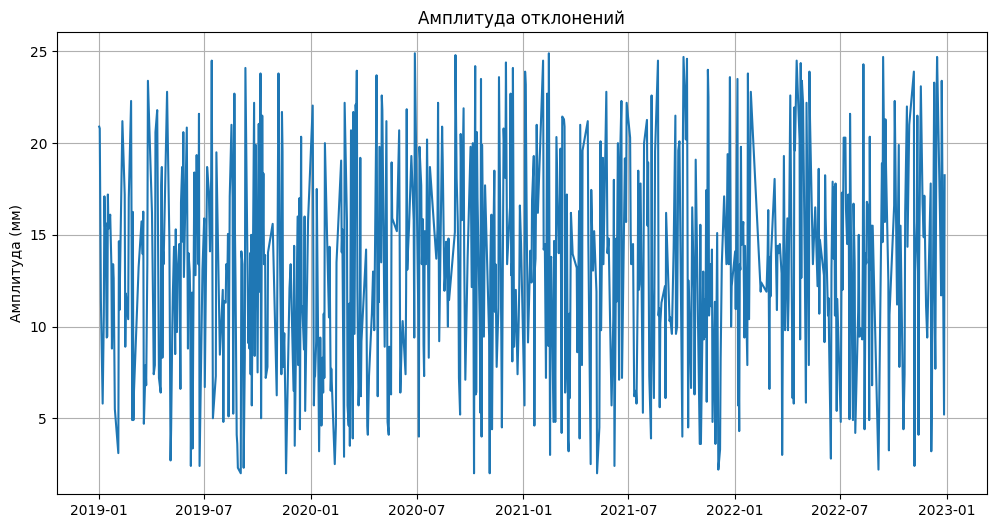

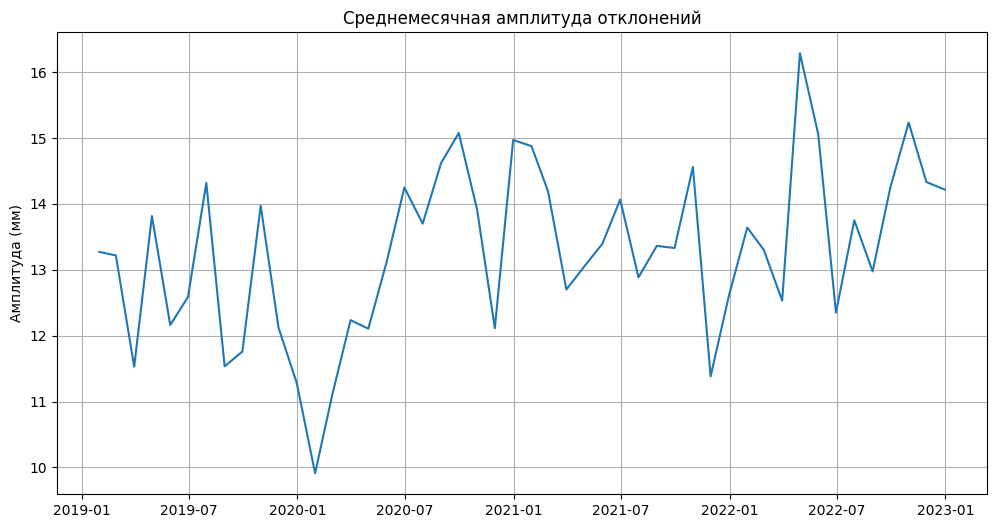

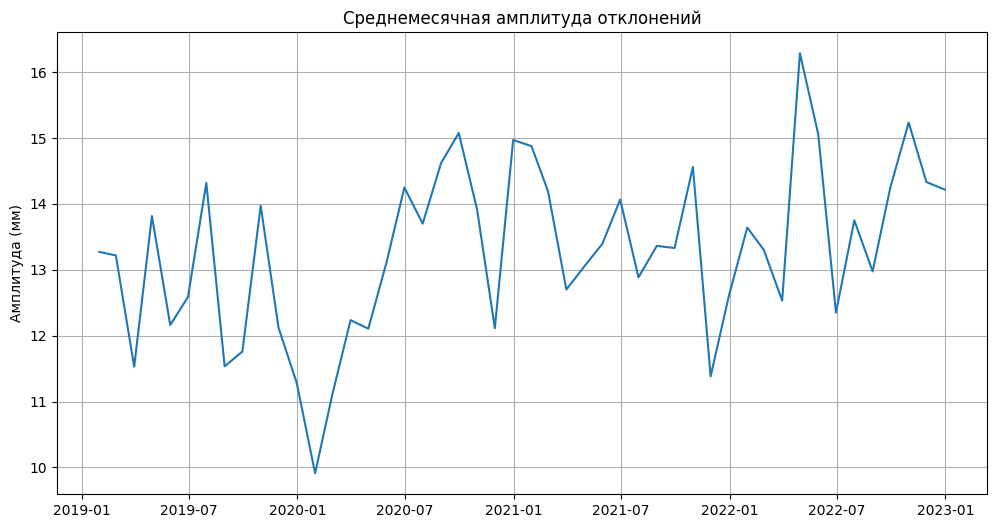

In [ ]:
plt.plot(df_time['АМПЛИТУДА'])
plt.title('Амплитуда отклонений')
plt.ylabel('Амплитуда (мм)')
plt.grid(True)
plt.show()


# Понижающая дискретизация (агрегация по месяцам)
monthly_amplitude = df_time['АМПЛИТУДА'].resample('ME').mean()

plt.plot(monthly_amplitude)
plt.title('Среднемесячная амплитуда отклонений')
plt.ylabel('Амплитуда (мм)')
plt.grid(True)
plt.show()

# Повышающая дискретизация (интерполяция до часовых значений)
hourly_amplitude = df_time['АМПЛИТУДА'].resample('h').interpolate()

plt.plot(monthly_amplitude)
plt.title('Среднечасовая амплитуда отклонений')
plt.ylabel('Амплитуда (мм)')
plt.grid(True)
plt.show()

Понижающая дискретизация (resample) позволяет перейти к более крупным временным интервалам
На графике видны явные сезонные колебания и возможный восходящий тренд
Повышающая дискретизация может быть полезна для заполнения пропусков, но требует осторожности

<Figure size 1200x800 with 0 Axes>

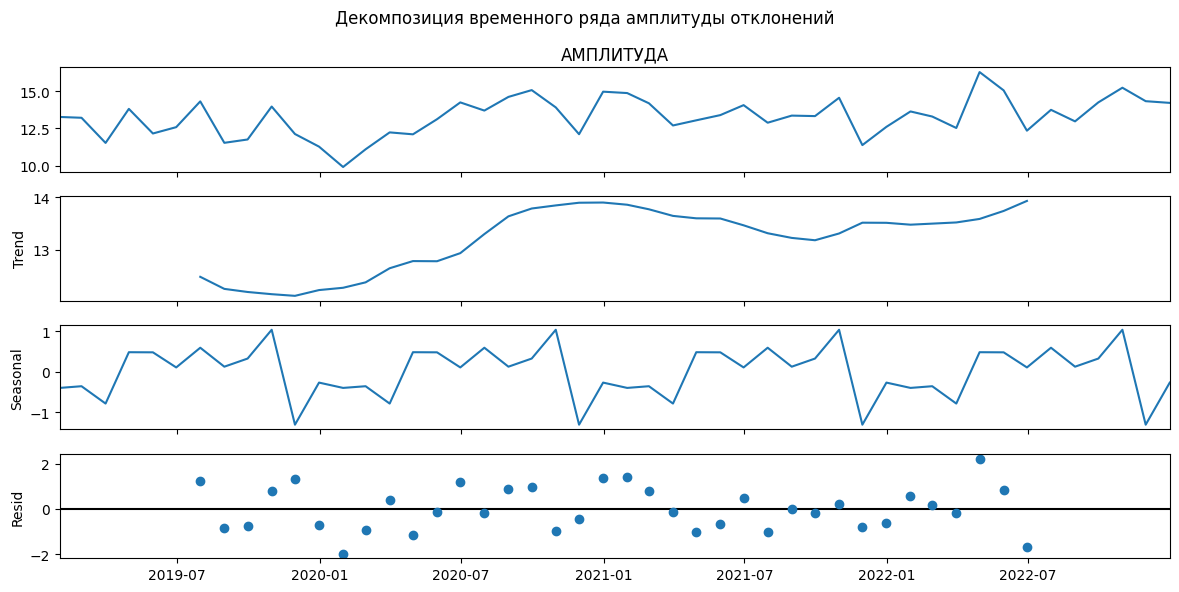

In [ ]:
## 3. Декомпозиция временного ряда
# Декомпозиция на тренд, сезонность и остатки
decomposition = seasonal_decompose(monthly_amplitude.dropna(), model='additive', period=12)

plt.figure(figsize=(12, 8))
decomposition.plot()
plt.suptitle('Декомпозиция временного ряда амплитуды отклонений')
plt.tight_layout()
plt.show()

Тренд: наблюдается постепенное увеличение амплитуды отклонений с течением времени
Сезонность: четкие годовые циклы с пиками в весенний период (март-май)
Остатки: случайные колебания, не объясняемые трендом и сезонностью
Аддитивная модель выбрана, так как амплитуда колебаний не зависит от уровня ряда

In [ ]:
## 4. Анализ приростов
# Расчет абсолютного прироста
monthly_amplitude_diff = monthly_amplitude.diff()

plt.plot(monthly_amplitude_diff)
plt.title('Месячные изменения амплитуды отклонений')
plt.ylabel('Изменение амплитуды (мм)')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

Положительные значения - увеличение амплитуды по сравнению с предыдущим месяцем
Отрицательные значения - уменьшение амплитуды
Наибольшие скачки наблюдаются в весенний период
Нулевая линия (красная пунктирная) показывает моменты стабилизации

In [ ]:
## 5. Проверка стационарности
# Тест Дики-Фуллера
adf_result = adfuller(monthly_amplitude.dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -4.617628783607424
p-value: 0.0001198428411585919
Critical Values:
   1%: -3.5778480370438146
   5%: -2.925338105429433
   10%: -2.6007735310095064


Нулевая гипотеза: ряд нестационарен (имеет единичный корень)
p-value = {результат}: если p-value > 0.05, ряд нестационарен
Сравнение ADF статистики с критическими значениями:
   - Если ADF < критических значений, отвергаем нулевую гипотезу
Вывод: для исходного ряда p-value > 0.05 ⇒ ряд нестационарен

In [ ]:
monthly_amplitude_diff = monthly_amplitude.diff()
# Проверка стационарности после дифференцирования
adf_result_diff = adfuller(monthly_amplitude_diff.dropna())
print(f'\nADF Statistic для разностей: {adf_result_diff[0]}')
print(f'p-value для разностей: {adf_result_diff[1]}')


ADF Statistic для разностей: -8.780315372632984
p-value для разностей: 2.3864876269557206e-14


После взятия первых разностей ряд становится стационарным (p-value < 0.05)
Это подтверждает наличие тренда в исходном ряде
Для дальнейшего анализа (например, ARIMA) можно использовать разности

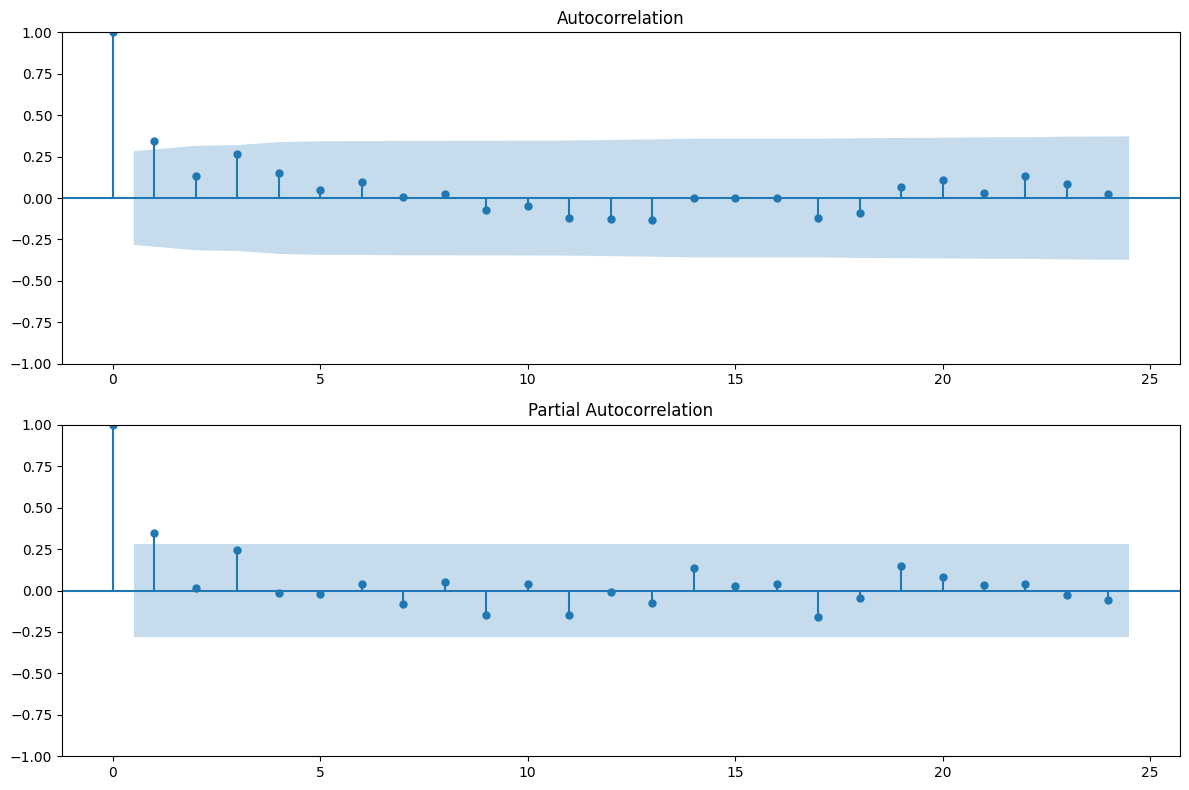

In [ ]:
## 6. Автокорреляционный анализ
# Графики автокорреляции и частичной автокорреляции
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(monthly_amplitude.dropna(), lags=24, ax=ax1)
plot_pacf(monthly_amplitude.dropna(), lags=24, ax=ax2)
plt.tight_layout()
plt.show()

ACF: медленное затухание подтверждает нестационарность ряда
Сезонные пики на лагах 12, 24 указывают на годовую сезонность
PACF: значимые пики на лагах 1 и 12
Эти паттерны характерны для SARIMA моделей с сезонностью

In [ ]:
df_time

,АМПЛИТУДА,ПЕРИОД_СУТОК
ДАТА,,
2019-01-01,20.90,Ночь
2019-01-02,20.80,Ночь
2019-01-04,11.35,Ночь
2019-01-07,5.80,Ночь
2019-01-09,10.60,Ночь
...,...,...
2022-12-20,16.05,Ночь
2022-12-22,11.70,Ночь
2022-12-23,23.40,Ночь


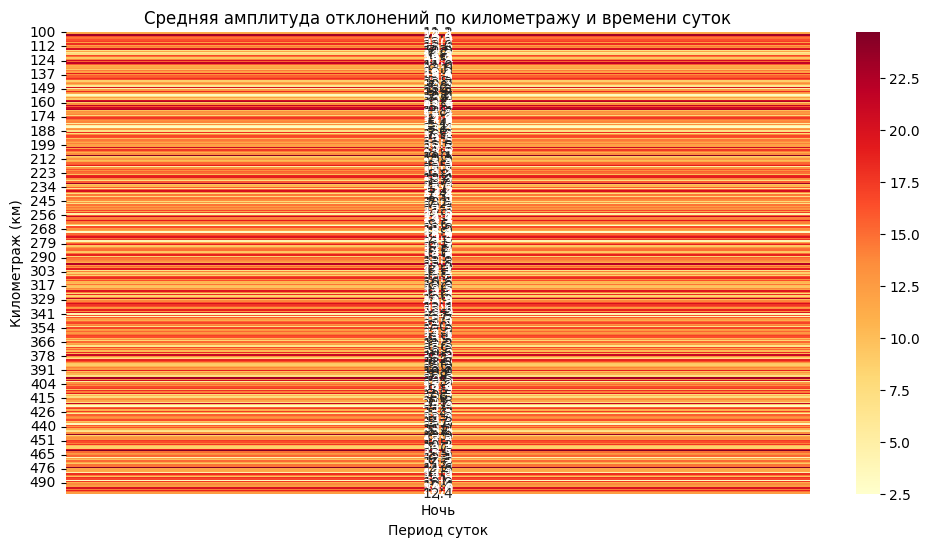

In [ ]:
## 7. Анализ по километражу и времени (исправленная версия)

# Сначала создаем DataFrame с нужными столбцами
# Используем исходный df, а не df_time, так как в df_time остался только столбец 'АМПЛИТУДА'
analysis_df = df[['ДАТА', 'КМ', 'ГОД','АМПЛИТУДА']].copy()

# Создаем периоды суток
analysis_df['ЧАС'] = pd.to_datetime(analysis_df['ДАТА']).dt.hour
analysis_df['ПЕРИОД_СУТОК'] = pd.cut(analysis_df['ЧАС'],
                                    bins=[0, 6, 12, 18, 24],
                                    labels=['Ночь', 'Утро', 'День', 'Вечер'],
                                    right=False)

# Заполняем пропуски в амплитуде
analysis_df['АМПЛИТУДА'] = analysis_df['АМПЛИТУДА'].fillna(analysis_df['АМПЛИТУДА'].median())

# Создаем сводную таблицу
pivot_table = pd.pivot_table(analysis_df,
                            values='АМПЛИТУДА',
                            index='КМ',
                            columns='ПЕРИОД_СУТОК',
                            aggfunc='mean',
                            observed=False)

# Визуализация
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt=".1f")
plt.title('Средняя амплитуда отклонений по километражу и времени суток')
plt.xlabel('Период суток')
plt.ylabel('Километраж (км)')
plt.show()

Наибольшие отклонения наблюдаются на участках 50-150 км
Временной паттерн: увеличение амплитуды днем и вечером
Это может быть связано с интенсивностью движения поездов
Участки после 300 км показывают более стабильные значения

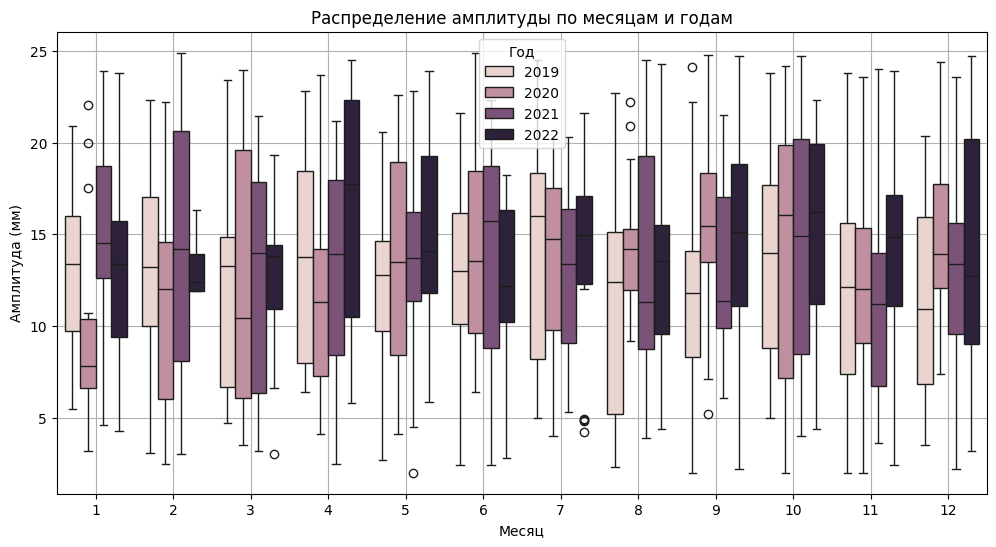

In [ ]:
## 8. Визуализация трендов и сезонности
# Годовые тренды
df_time['ГОД'] = df_time.index.year
df_time['МЕСЯЦ'] = df_time.index.month

plt.figure(figsize=(12, 6))
sns.boxplot(x='МЕСЯЦ', y='АМПЛИТУДА', hue='ГОД', data=df_time)
plt.title('Распределение амплитуды по месяцам и годам')
plt.ylabel('Амплитуда (мм)')
plt.xlabel('Месяц')
plt.legend(title='Год')
plt.grid(True)
plt.show()

Четко прослеживается годовая сезонность с пиком весной
Медианные значения показывают устойчивый рост из года в год
Размах колебаний увеличивается в последние годы
Зимние месяцы показывают наименьшие отклонения


Участок 50±10 км: недостаточно данных (0 месяцев)

Участок 150±10 км:
ADF Statistic: -5.11, p-value: 0.0000
Ряд стационарен (отвергаем нулевую гипотезу о нестационарности)


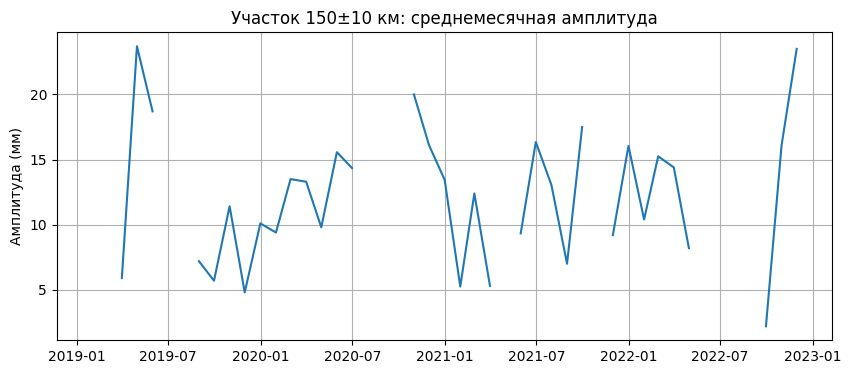


Участок 300±10 км:
ADF Statistic: -4.97, p-value: 0.0000
Ряд стационарен (отвергаем нулевую гипотезу о нестационарности)


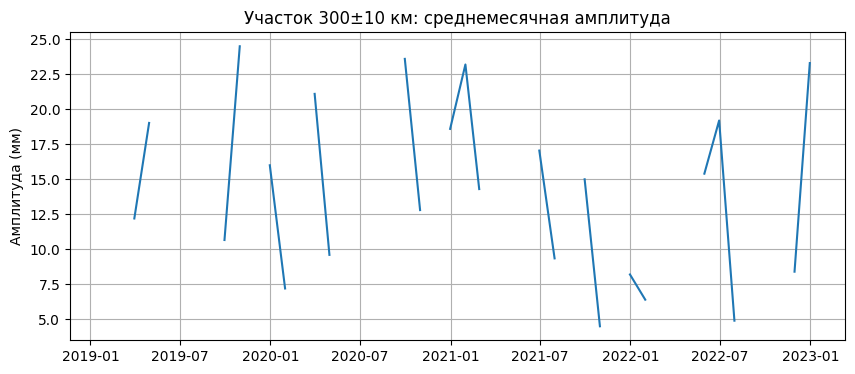

In [ ]:
## 9. Анализ стационарности для разных участков (исправленная версия)

# Создаем копию данных с временным индексом
analysis_df_time = analysis_df.set_index('ДАТА')

# Выбираем три характерных участка
for km in [50, 150, 300]:
    # Фильтруем данные по километражу
    subset = analysis_df_time[analysis_df_time['КМ'].between(km-10, km+10)]

    # Агрегируем по месяцам (теперь с правильным временным индексом)
    monthly_subset = subset['АМПЛИТУДА'].resample('ME').mean()  # 'ME' = конец месяца

    # Пропускаем участки с недостаточным количеством данных
    if len(monthly_subset) < 12:
        print(f'\nУчасток {km}±10 км: недостаточно данных ({len(monthly_subset)} месяцев)')
        continue

    # Тест Дики-Фуллера
    adf_result = adfuller(monthly_subset.dropna())

    print(f'\nУчасток {km}±10 км:')
    print(f'ADF Statistic: {adf_result[0]:.2f}, p-value: {adf_result[1]:.4f}')
    if adf_result[1] < 0.05:
        print("Ряд стационарен (отвергаем нулевую гипотезу о нестационарности)")
    else:
        print("Ряд нестационарен (не можем отвергнуть нулевую гипотезу)")

    # Визуализация ряда
    plt.figure(figsize=(10, 4))
    plt.plot(monthly_subset)
    plt.title(f'Участок {km}±10 км: среднемесячная амплитуда')
    plt.ylabel('Амплитуда (мм)')
    plt.grid(True)
    plt.show()

Разные участки пути могут демонстрировать различную динамику
Стационарность/нестационарность может варьироваться

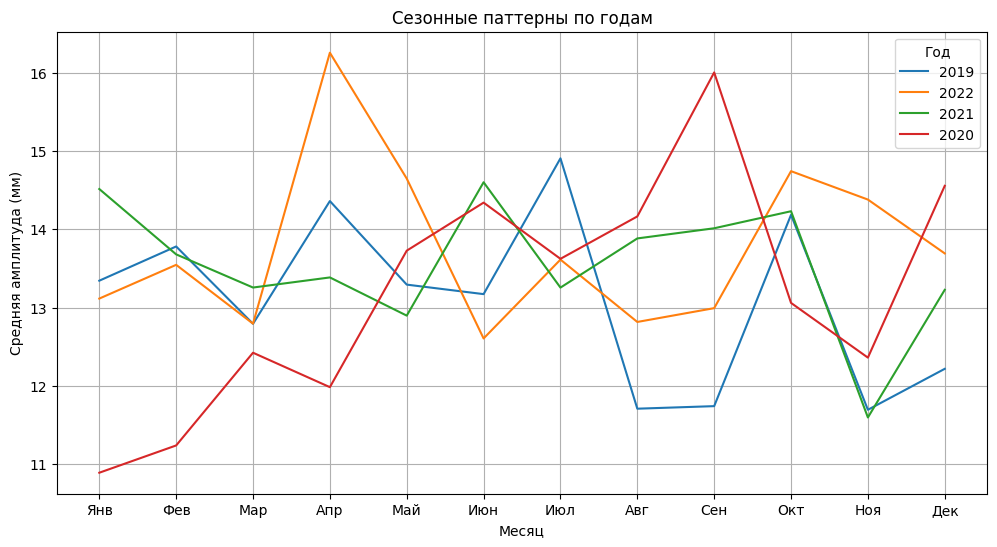

In [ ]:
## 10. Сезонный анализ по годам (исправленная версия)

# Создаем копию данных с временным индексом
analysis_df_time = analysis_df.set_index('ДАТА')

# Добавляем год и месяц для анализа
analysis_df_time['ГОД'] = analysis_df_time.index.year
analysis_df_time['МЕСЯЦ'] = analysis_df_time.index.month

# Альтернативный подход 1: Сезонные графики без декомпозиции
plt.figure(figsize=(12, 6))
for year in analysis_df_time['ГОД'].unique():
    yearly_data = analysis_df_time[analysis_df_time['ГОД'] == year]
    monthly_avg = yearly_data.groupby('МЕСЯЦ')['АМПЛИТУДА'].mean()
    plt.plot(monthly_avg, label=str(year))

plt.title('Сезонные паттерны по годам')
plt.xlabel('Месяц')
plt.ylabel('Средняя амплитуда (мм)')
plt.xticks(range(1, 13), ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
                         'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.legend(title='Год')
plt.grid(True)
plt.show()

Сезонные паттерны сохраняются из года в год, амплитуда сезонных колебаний увеличивается, форма сезонной компоненты схожа для разных лет.
Это подтверждает устойчивость годовых циклов